In [19]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import re #regex
import os
from datetime import date, datetime, timedelta
import math
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
import seaborn as sns
# Set style & figures inline
sns.set()
%matplotlib inline

## Web Scrapping Functions

In [20]:
# Extracts data from the webpage using lxml.html
def extract_table(url,xpath_all,contains_header):
    
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)

    col_all=[]
    nrows=[] # number of rows for each table
    
    for xpath in xpath_all:
        print("Path used in collecting data: {}".format(xpath))
        #Parse data that are stored between <tr>..</tr> of HTML
        tr_elements = doc.xpath(xpath)
        
        #Check the number of columns of the first 12 rows
        print("Number of columns of the table:")
        print([len(T) for T in tr_elements[:18]])

        #Create empty list
        #tables that store a header (if there's one) and data
        #assuming all tables have the same header
        col=[]  

        ## Getting header
        i=0
        #For each row, store each first element (header)
        #and an empty list
        print("Table Header:")
        for t in tr_elements[0]:
            if contains_header==True:
                name=t.text_content()
            else:
                name=contains_header[i]
            i+=1
            print('%d:"%s"'%(i,name))
            col.append((name,[]))
            
        ## Getting data
        if contains_header==True:
            start_ind = 1
        else:
            start_ind = 0

        #nrows_current = 0
        for j in range(start_ind,len(tr_elements)):

            # break if reaching end of table
            #if len(tr_elements[j]) != len(tr_elements[0]):
            if j > 14:
                break
            i = 0    
            for ele in tr_elements[j].iterchildren():
                data = ele.text_content().strip()

                #check data
                p1 = re.search("^[A-Za-z]+", data)
                p2 = re.search('^[0-9,]+[\\n]*', data)

                if p1:
                    col[i][1].append(data)
                elif p2:
                    value = data[:p2.span()[1]].replace(",","")
                    if (re.search("\\n", value)):
                        value = value[:-1]
                    col[i][1].append(int(value))

                #Increment i for the next column
                i+=1
            
        col_all.append(col)
    return col_all

# Stores extracted data into dataframe(s)
def create_dataframe(table,num_table):

    df_all = pd.DataFrame()

    for t in range(0,num_table):
        Dict={title:column for (title,column) in table[t]}
        df=pd.DataFrame(Dict)
        df['Date'] = date.today()
        df_all=df_all.append(df,ignore_index=True)

    return df_all

## Extract data from the web

In [33]:
# Obtained data from the following website
url='https://www.covid-19canada.com'
#xpath1_1='//tr'
xpath1_1='//table[@id="canada-board"]//tr'
header = ["Province", "Total Confirmed", "Total Deaths", "Total Recovered", "Total Active"]
data = extract_table(url,[xpath1_1], contains_header=header)

#print(data)

Path used in collecting data: //table[@id="canada-board"]//tr
Number of columns of the table:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Table Header:
1:"Province"
2:"Total Confirmed"
3:"Total Deaths"
4:"Total Recovered"
5:"Total Active"


In [34]:
df_1 = create_dataframe(data,len([xpath1_1]))

#remvoe the first row (header)
df_1.drop(labels = [0], axis = 0, inplace = True)
df_1.reset_index(drop = True, inplace = True)
print(df_1)

   Province Total Confirmed Total Deaths Total Recovered Total Active  \
0     Total          506057        14200          415122        76735   
1        BC           45400          724           33589        11087   
2        ON          155930         4150          133213        18567   
3        QC          176985         7736          151044        18205   
4        AB           88933          841           68832        19260   
5        MB           22630          556           16406         5668   
6        NB             578            8             520           50   
7        SK           13329          115            9452         3762   
8       PEI              90            0              73           17   
9        NL             382            4             344           34   
10       NS            1445           65            1339           41   
11       YT              59            1              57            1   
12       NT              24            0           

## Combine new daily extracted data to previous data

In [35]:
### Export the current df to existing file (previous data)
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")
os.makedirs(save_path, exist_ok = True)

num_dataset = len(df_1.index)


for i in range(num_dataset):
    temp_df = df_1.loc[df_1[df_1.columns[0]] == df_1.loc[i][df_1.columns[0]]]

    #load current df and then perform merge before saving
    file_fullpath = os.path.join(save_path,df_1.loc[i][df_1.columns[0]] + ".csv")
    if os.path.exists(file_fullpath):
        orig_dataset = pd.read_csv(file_fullpath)    
        
        #reindex new df to match with existing data
        temp_df.reindex(columns=orig_dataset.columns)
        
        new_dataset = pd.merge(orig_dataset, temp_df, how = 'outer', on = list(orig_dataset.columns))
        new_dataset.drop_duplicates(subset=['Total Confirmed','Date'], keep = 'first', inplace = True)
        #print(new_dataset)
        new_dataset.to_csv(file_fullpath, index = False)
    else:
        temp_df.to_csv(file_fullpath, index = False)

## Examine the data

****** Total ******

           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2020-12-17    Total         485923.0       13844.0         395330.0   
2020-12-18    Total         493056.0       14002.0         402845.0   
2020-12-19    Total         499741.0       14111.0         409323.0   
2020-12-19    Total         499743.0       14111.0         409327.0   
2020-12-20    Total         506057.0       14200.0         415122.0   

            Total Active  
Date                      
2020-12-17       76749.0  
2020-12-18       76209.0  
2020-12-19       76307.0  
2020-12-19       76305.0  
2020-12-20       76735.0  


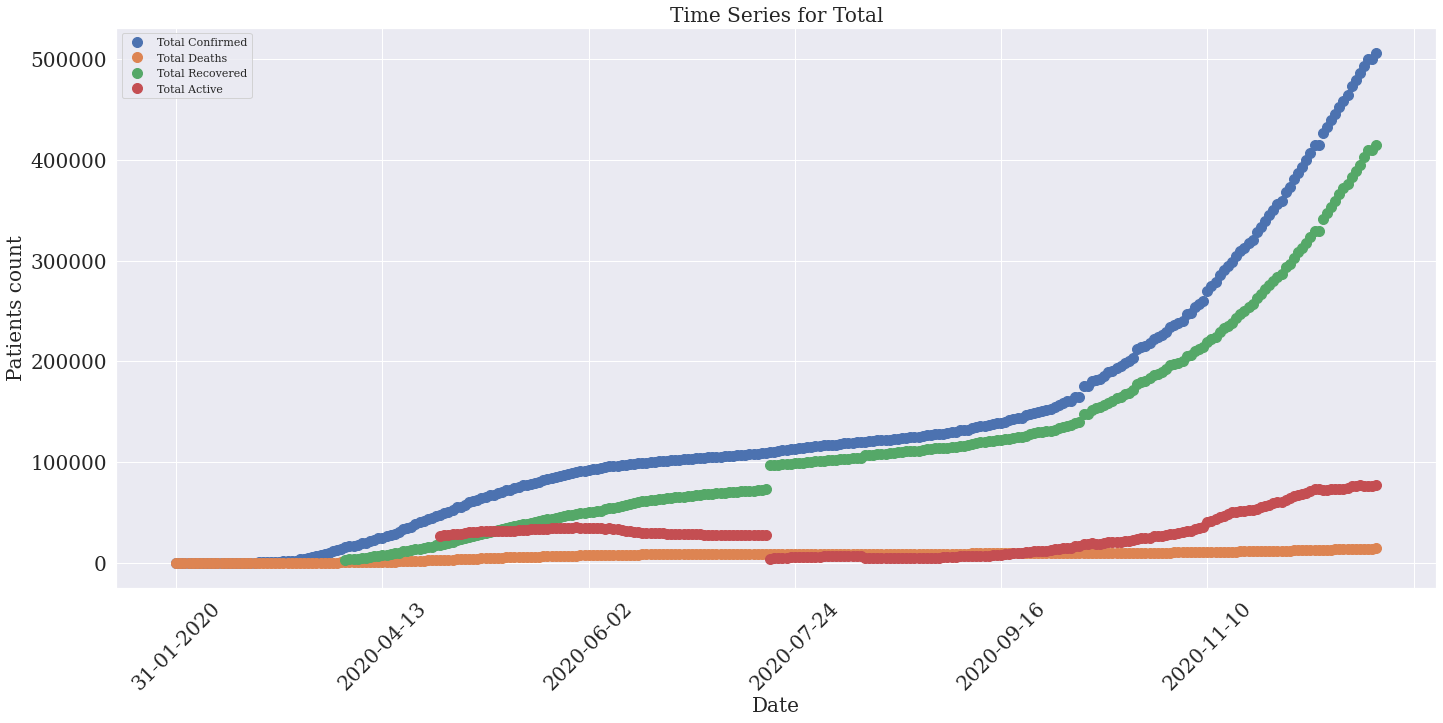

****** ON ******

           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2020-12-16       ON         146535.0        4035.0         125416.0   
2020-12-17       ON         148967.0        4058.0         127425.0   
2020-12-18       ON         151257.0        4098.0         129417.0   
2020-12-19       ON         153614.0        4125.0         131282.0   
2020-12-20       ON         155930.0        4150.0         133213.0   

            Total Active  
Date                      
2020-12-16       17084.0  
2020-12-17       17484.0  
2020-12-18       17742.0  
2020-12-19       18207.0  
2020-12-20       18567.0  


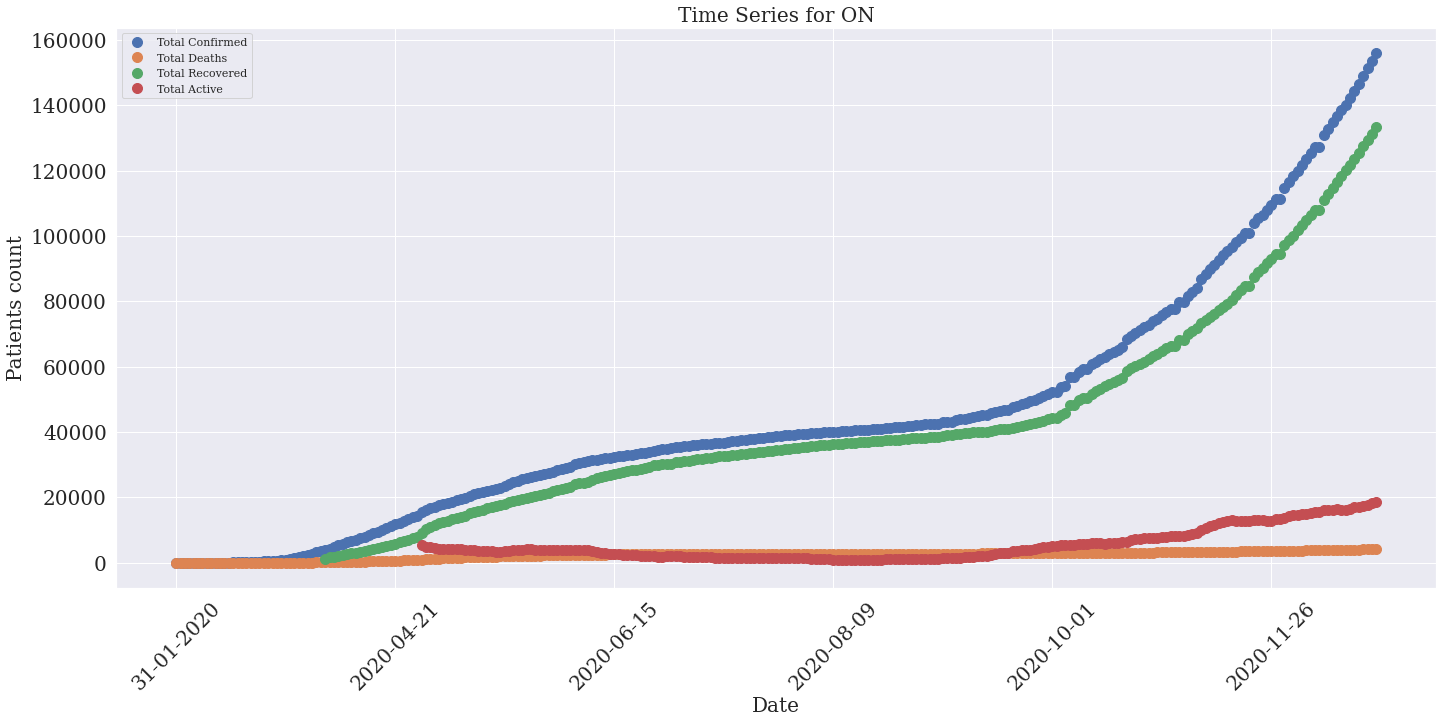

****** QC ******

           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2020-12-16       QC         169173.0        7613.0         144168.0   
2020-12-17       QC         171028.0        7635.0         145532.0   
2020-12-18       QC         172801.0        7671.0         147398.0   
2020-12-19       QC         174839.0        7715.0         149245.0   
2020-12-20       QC         176985.0        7736.0         151044.0   

            Total Active  
Date                      
2020-12-16       17392.0  
2020-12-17       17861.0  
2020-12-18       17732.0  
2020-12-19       17879.0  
2020-12-20       18205.0  


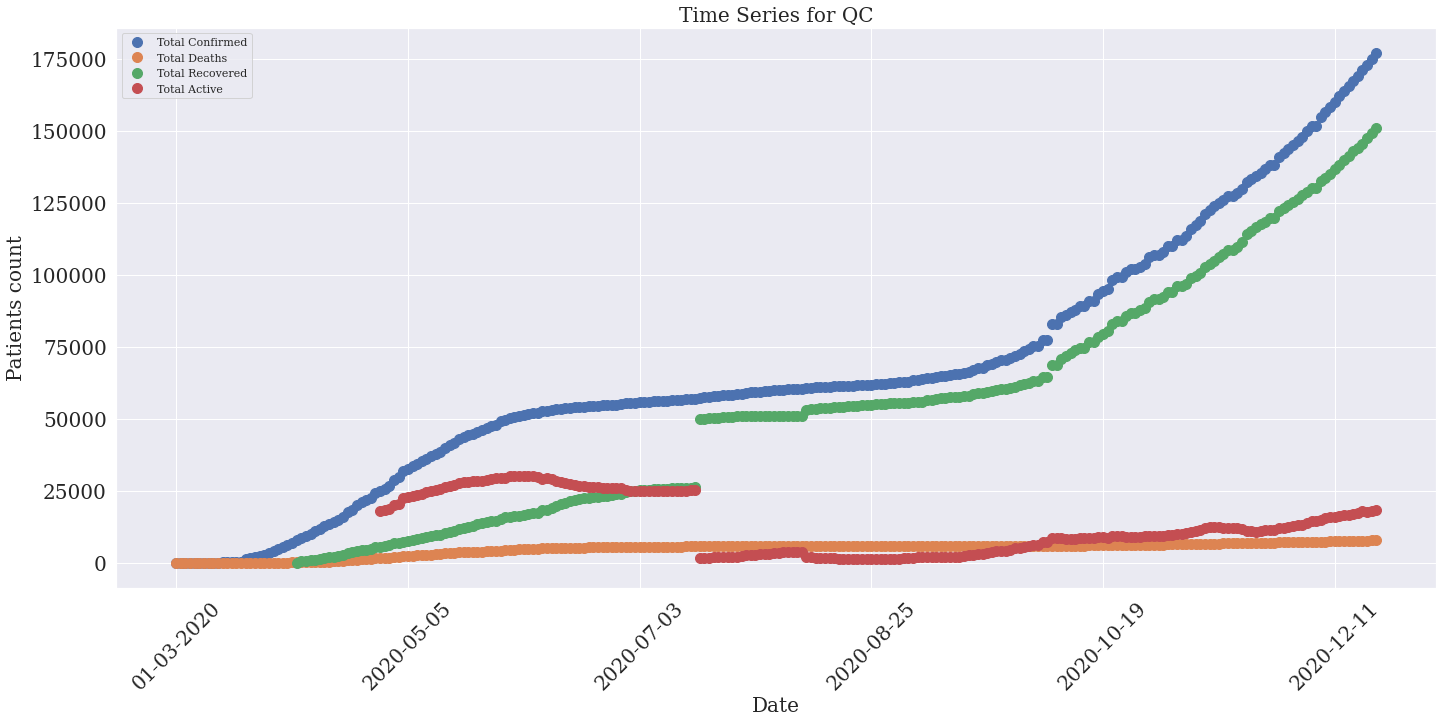

****** BC ******

           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2020-12-16       BC          43463.0         668.0          31866.0   
2020-12-17       BC          44103.0         692.0          32376.0   
2020-12-18       BC          44776.0         713.0          32963.0   
2020-12-19       BC          45400.0         724.0          33589.0   
2020-12-20       BC          45400.0         724.0          33589.0   

            Total Active  
Date                      
2020-12-16       10929.0  
2020-12-17       11035.0  
2020-12-18       11100.0  
2020-12-19       11087.0  
2020-12-20       11087.0  


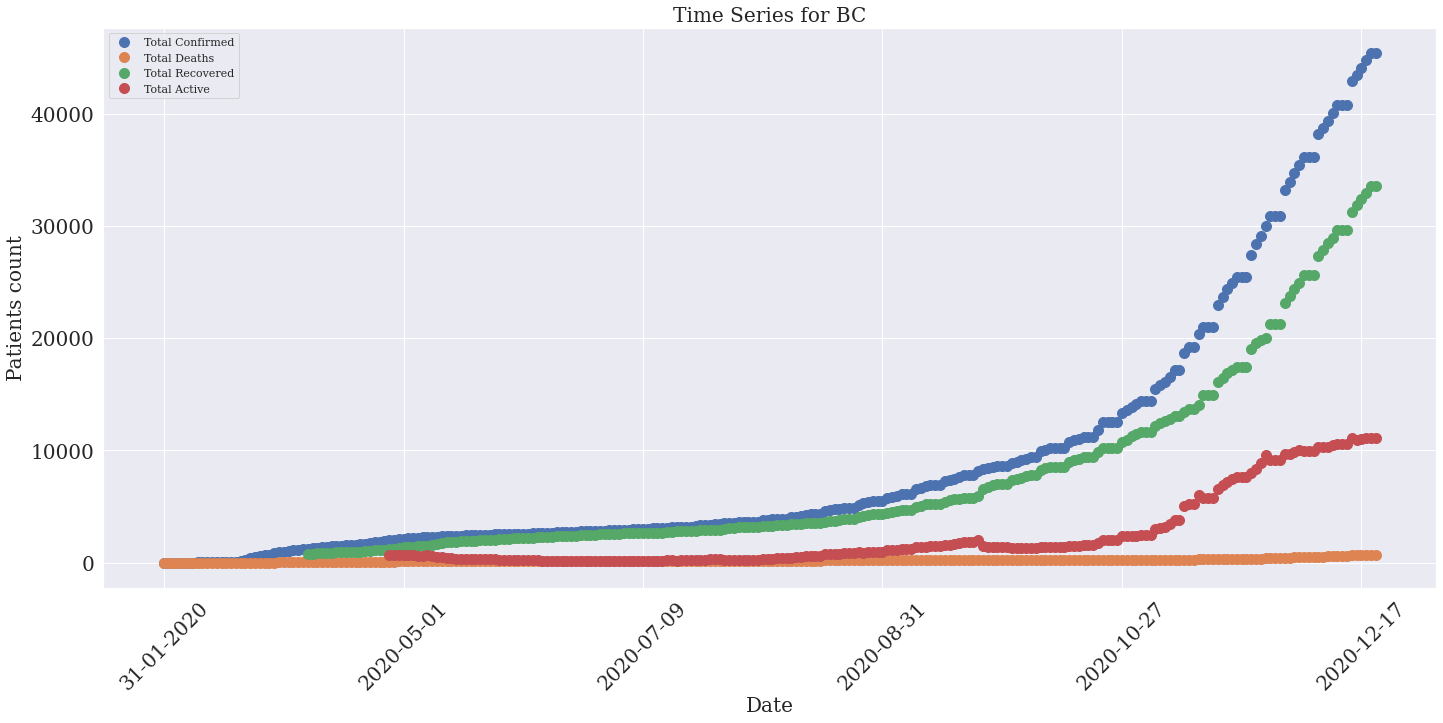

****** AB ******

           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2020-12-16       AB          83327.0         744.0          61934.0   
2020-12-17       AB          84597.0         760.0          63668.0   
2020-12-18       AB          86168.0         790.0          65513.0   
2020-12-19       AB          87581.0         815.0          67159.0   
2020-12-20       AB          88933.0         841.0          68832.0   

            Total Active  
Date                      
2020-12-16       20649.0  
2020-12-17       20169.0  
2020-12-18       19865.0  
2020-12-19       19607.0  
2020-12-20       19260.0  


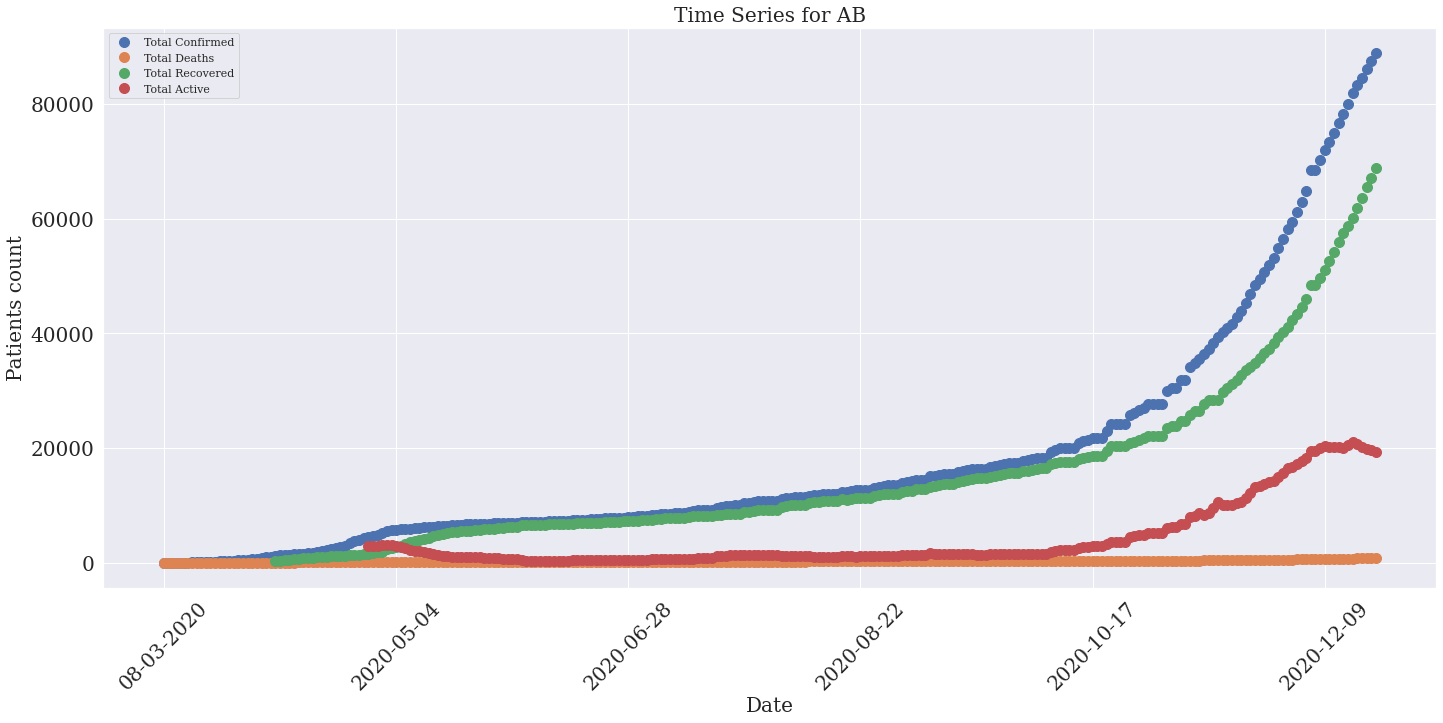

In [36]:
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")

# select the provinces to look at
target = ['Total', 'ON', 'QC', 'BC', 'AB']

df = []
# import updated data
for i in range(len(target)):
    file_fullpath = os.path.join(save_path, target[i] + ".csv")
    df_temp = pd.read_csv(file_fullpath)
    df_temp.drop_duplicates(subset=['Total Confirmed','Date'], keep = 'first', inplace = True)
    #print(df_temp.tail(2))
    #continue
    df_temp = df_temp.set_index('Date')
    print('****** ' + df_temp['Province'][0] + ' ******\n')
    print(df_temp.tail(5))
    df_temp.iloc[:, 1:5].plot(figsize=(20,10), style='o', ms=10, fontsize=20, rot = 45)
    df.append(df_temp)
    plt.xlabel('Date', fontsize=20);
    plt.ylabel('Patients count', fontsize=20);
    plt.title('Time Series for ' + target[i], fontsize=20)
    plt.show()

## 1st Model Fitting: Gaussian

In [37]:
# function for fitting (normal distribution function)
def func_normal(x,a,x0,sigma):
    return (a/sigma)*np.exp(-(x-x0)**2/(2*sigma**2))

# specify the formats of dates in the dataset
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d', '%d-%m-%Y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')
    
# dividing zero function
def divison(r,d):
    return (r / d if d != 0 else r)

In [38]:
# computes the weekly average
def getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day):
    df = pd.DataFrame(data = {'Date': xdata, 
                              'Date_Num': x_data_in_day, 
                              'Daily_Increase': y_data_change_per_day})
    df['Date_formatted'] = pd.to_datetime(df['Date'], format="%d-%m-%Y",  errors='coerce')
    mask = df.Date_formatted.isnull()
    df.loc[mask, 'Date_formatted'] = pd.to_datetime(df[mask]['Date'], format="%Y-%m-%d", errors='coerce')
    df['Week'] = df['Date_formatted'].dt.week
    df['Week_midpoint'] = df.groupby('Week')[['Date_Num']].transform('median')
    #print(df.head(10))
    #print(df.groupby('Week')['Date_formatted'].transform('min'))
    weekly_avg = df.groupby('Week')[['Week_midpoint','Daily_Increase']].mean()
    #print(weekly_avg)
    return weekly_avg


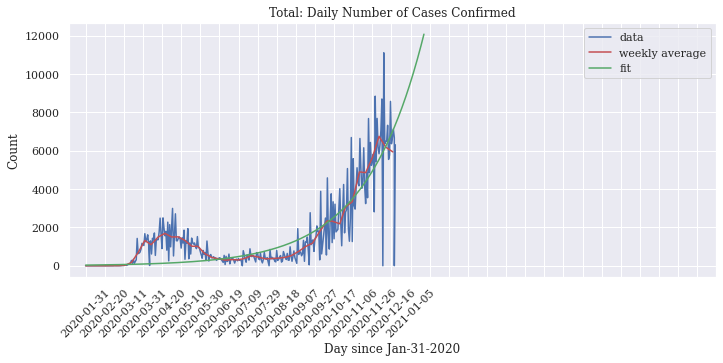

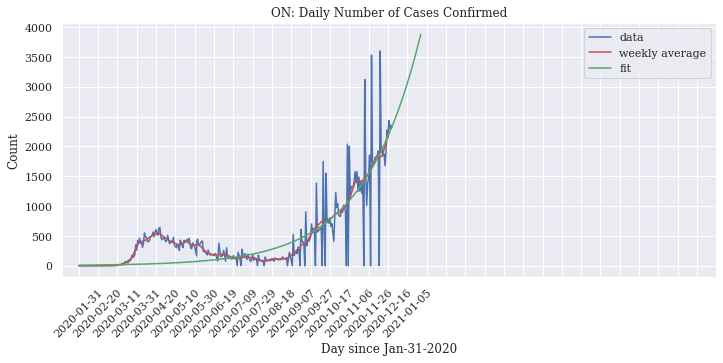

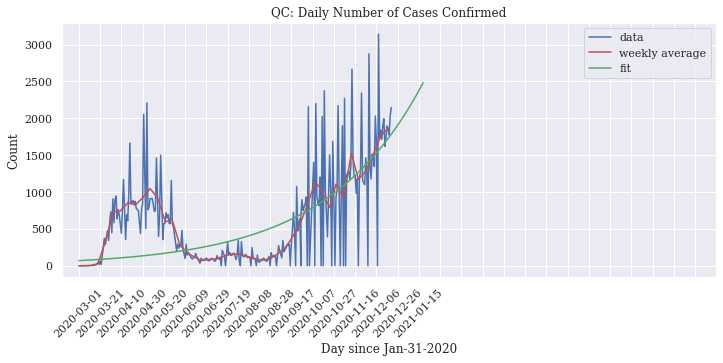

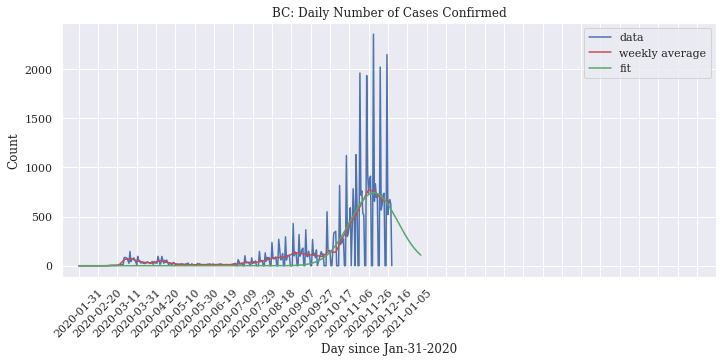

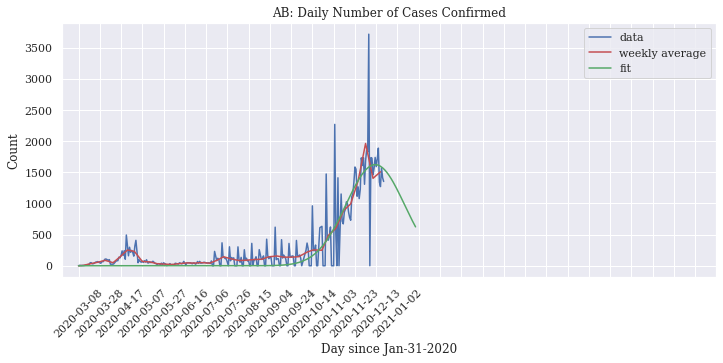

In [51]:
for cur_df in df:
    ydata = cur_df.iloc[:, 1].transpose()
    xdata = cur_df.index
    x_data_2 = [try_parsing_date(x) for x in xdata]
    
    # convert time to days since first record
    x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
    x_data_in_day  = np.array([x / 3600 / 24 for x in x_data_in_sec])
    
    # compute the increase in confirmed cases from total
    x_data_in_day_diff = np.ediff1d(x_data_in_day, to_begin=0)
    y_data_change = np.ediff1d(ydata, to_begin=0)
    y_data_change_per_day = np.array([divison(y,x) for x,y in zip(x_data_in_day_diff, y_data_change)])
    
    # compute the weekly average
    weekly_avg = getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day)
    
    # ignore datapoints where count is zero
    #nonzero_indices = np.where(y_data_change_per_day != 0.0)[0]
    #x_data_in_day = x_data_in_day[nonzero_indices]
    #y_data_change_per_day = y_data_change_per_day[nonzero_indices]

    
    # compute the curvefit
    n = len(x_data_in_day)
    mean = float(sum(y_data_change_per_day))
    sigma = np.sqrt(sum((y_data_change_per_day-mean)**2))
    init_vals = [1000, mean, sigma]
       
    # fit your data and getting fit parameters
    popt, pcov = curve_fit(func_normal, x_data_in_day, y_data_change_per_day, p0=init_vals, maxfev = 100000)
    
    
    # Create the figures
    x_end = math.ceil(x_data_in_day[len(x_data_in_day)-1])
    x_extend = np.array(range(x_end, x_end+31))
    
    xdisplay = [ (try_parsing_date(cur_df.index[0])+timedelta(days=t)).strftime("%Y-%m-%d") for t in range(0,max(x_extend))]
        
    #plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
    #plt.rcParams.update({'font.size': 42})
    plt.rcParams.update({'figure.autolayout': True, 'font.size': 5, 'font.family': 'serif', 'font.sans-serif': ['Helvetica']})    
    
    plt.plot(x_data_in_day, y_data_change_per_day, 'b-', label='data')
    
    plt.plot(weekly_avg['Week_midpoint'], weekly_avg['Daily_Increase'], 'r-', label = 'weekly average')
    
    plt.plot(np.concatenate((x_data_in_day, x_extend)), 
             func_normal(np.concatenate((x_data_in_day, x_extend)), *popt), 
             'g-', label='fit')
    #plt.plot(x_data_in_day, 
    #         func_normal(x_data_in_day, *popt), 
    #         'g-', label='fit')
    
    plt.xticks(np.arange(0, max(x_data_in_day) + max(x_extend), step = 20), labels = xdisplay[::20], rotation=45)
    
    plt.xlabel('Day since Jan-31-2020')
    plt.ylabel('Count')
    plt.title(cur_df['Province'][0] + ': Daily Number of Cases Confirmed')
    plt.legend()
    plt.show()
    
    from sklearn.metrics import mean_squared_error
    # Calculation of Mean Squared Error (MSE) 
    y_pred = np.array(func_normal(x_data_in_day, *popt))
    #print("MSE: {}".format(mean_squared_error(y_data_change_per_day, y_pred)))


## 2nd model: Linear Regression on Cum. Cases in Logarithmic scale

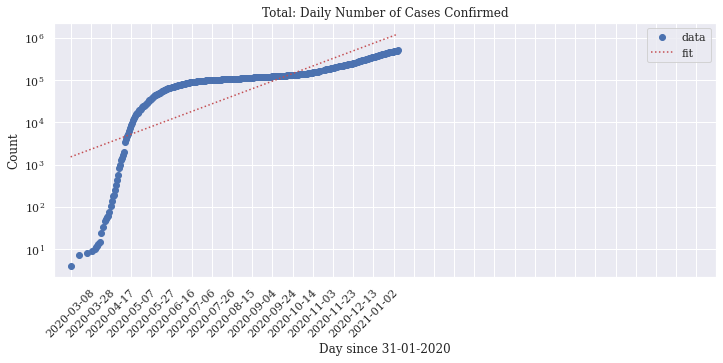

In [100]:
for cur_df in df[0:1][:]:
    xdata = cur_df.index
    x_data_2 = [try_parsing_date(x) for x in xdata]
    #print(xdata)
    ydata = cur_df.iloc[:, 1]#.transpose()
    ydata.dropna(inplace=True)
    #print(np.isfinite(ydata).all())
    #print(ydata)
    
    x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
    x_data_in_day  = [x / 3600 / 24 for x in x_data_in_sec]
    
    # curve fit, in log scale for y
    m, c = np.polyfit(x_data_in_day, np.log(ydata), 1) # fit log(y) = m*log(x) + c
    y_fit = np.exp([m*x + c for x in x_data_in_day]) # calculate the fitted values of y 

    #Plot: log scale in y-axis
    fig,ax = plt.subplots(1, 1, figsize=(10,5))
    ax.set_yscale('log', basey=10)

    plt.rcParams.update({'font.size': 42})
    plt.rcParams.update({'figure.autolayout': True, 'font.size': 5, 'font.family': 'serif', 'font.sans-serif': ['Helvetica']})    

    plt.plot(x_data_in_day, ydata, 'bo', label='data')
    plt.plot(x_data_in_day, y_fit, 'r:', label='fit')
    
    plt.xticks(np.arange(0, max(x_data_in_day) + max(x_extend), step = 20), labels = xdisplay[::20], rotation=45)
    plt.xlabel('Day since '+xdata[0])
    plt.ylabel('Count')
    plt.title(cur_df['Province'][0] + ': Daily Number of Cases Confirmed')
    plt.legend()
    plt.show()
    
    
    '''
    #Plot: log scale in y-axis
    fig,ax = plt.subplots(1, 1, figsize=(10,5))
    ax.set_yscale('log', basey=10)
    
    ax.plot(x_data_in_day, ydata, 'bo', label='data')
    ax.plot(x_data_in_day, y_fit, 'r:', label='fit')
    
    plt.xticks(np.arange(0, max(x_data_in_day) + max(x_extend), step = 20), labels = xdisplay[::20], rotation=45)
    #ax.set_xticks(np.arange(0, max(x_data_in_day) + max(x_extend), step = 50))
    ax.set_xlabel('Day since '+xdata[0])
    ax.set_ylabel('Cumulative confirmed cases [Log scale]')
    ax.set_title(cur_df['Province'][0] + ' : Number of Cases Confirmed')
    
    '''